In [1]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation, FFMpegWriter

## Single Pendulum Simulation

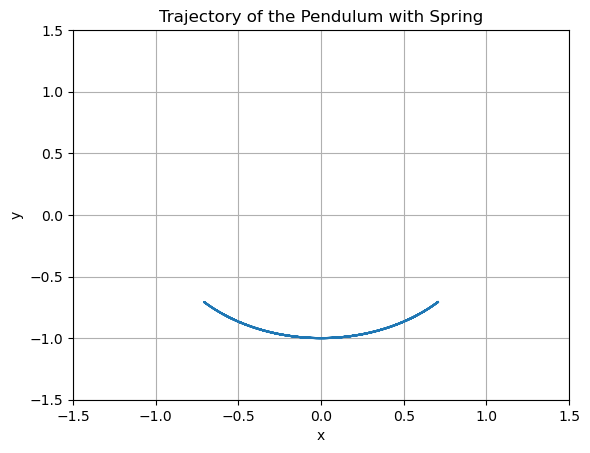

array([[ 0.70710678, -0.70710678],
       [ 0.70710678, -0.70711659],
       [ 0.70710629, -0.70713572],
       ...,
       [-0.58466712, -0.81146936],
       [-0.5858156 , -0.81062203],
       [-0.58695566, -0.80977284]])

In [2]:
# Constants
g = 9.81  # Gravitational acceleration (positive value for downward)
m = 0.1  # Mass of the pendulum
l0 = 1  # Natural length of the spring
dt = 0.001  # Time step
t_max = 5  # Total simulation time
k = 10000  # Spring constant

# Number of steps
n = int(t_max / dt)

# Arrays to store values
a = np.zeros((n, 2))
v = np.zeros((n, 2))
x = np.zeros((n, 2))
t = np.zeros(n) 

# Initial conditions
x[0] = [0.5**0.5, -0.5**0.5]

# Simulation loop
for i in range(n - 1):
    l = np.sqrt(x[i][0]**2 + x[i][1]**2)
    # Calculate the spring force magnitude
    F_s = - k * (l - l0)

    # Normalize the direction vector
    dir_x = x[i][0] / l # sin(theta)
    dir_y = x[i][1] / l # cos(theta)
    
    sigmaF = np.array([dir_x * F_s, dir_y * F_s - m * g])

    # Update acceleration
    a[i + 1] = sigmaF / m

    # Update velocity
    v[i + 1] = v[i] + dt * a[i + 1]

    # Update position
    x[i + 1] = x[i] + dt * v[i + 1]

    # Update time
    t[i + 1] = t[i] + dt

# Plotting the trajectory
plt.plot(x[:, 0], x[:, 1])
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory of the Pendulum with Spring')
plt.grid(True)
plt.show()
x

## Double Pendulum Simulation With the Same Pivot Point

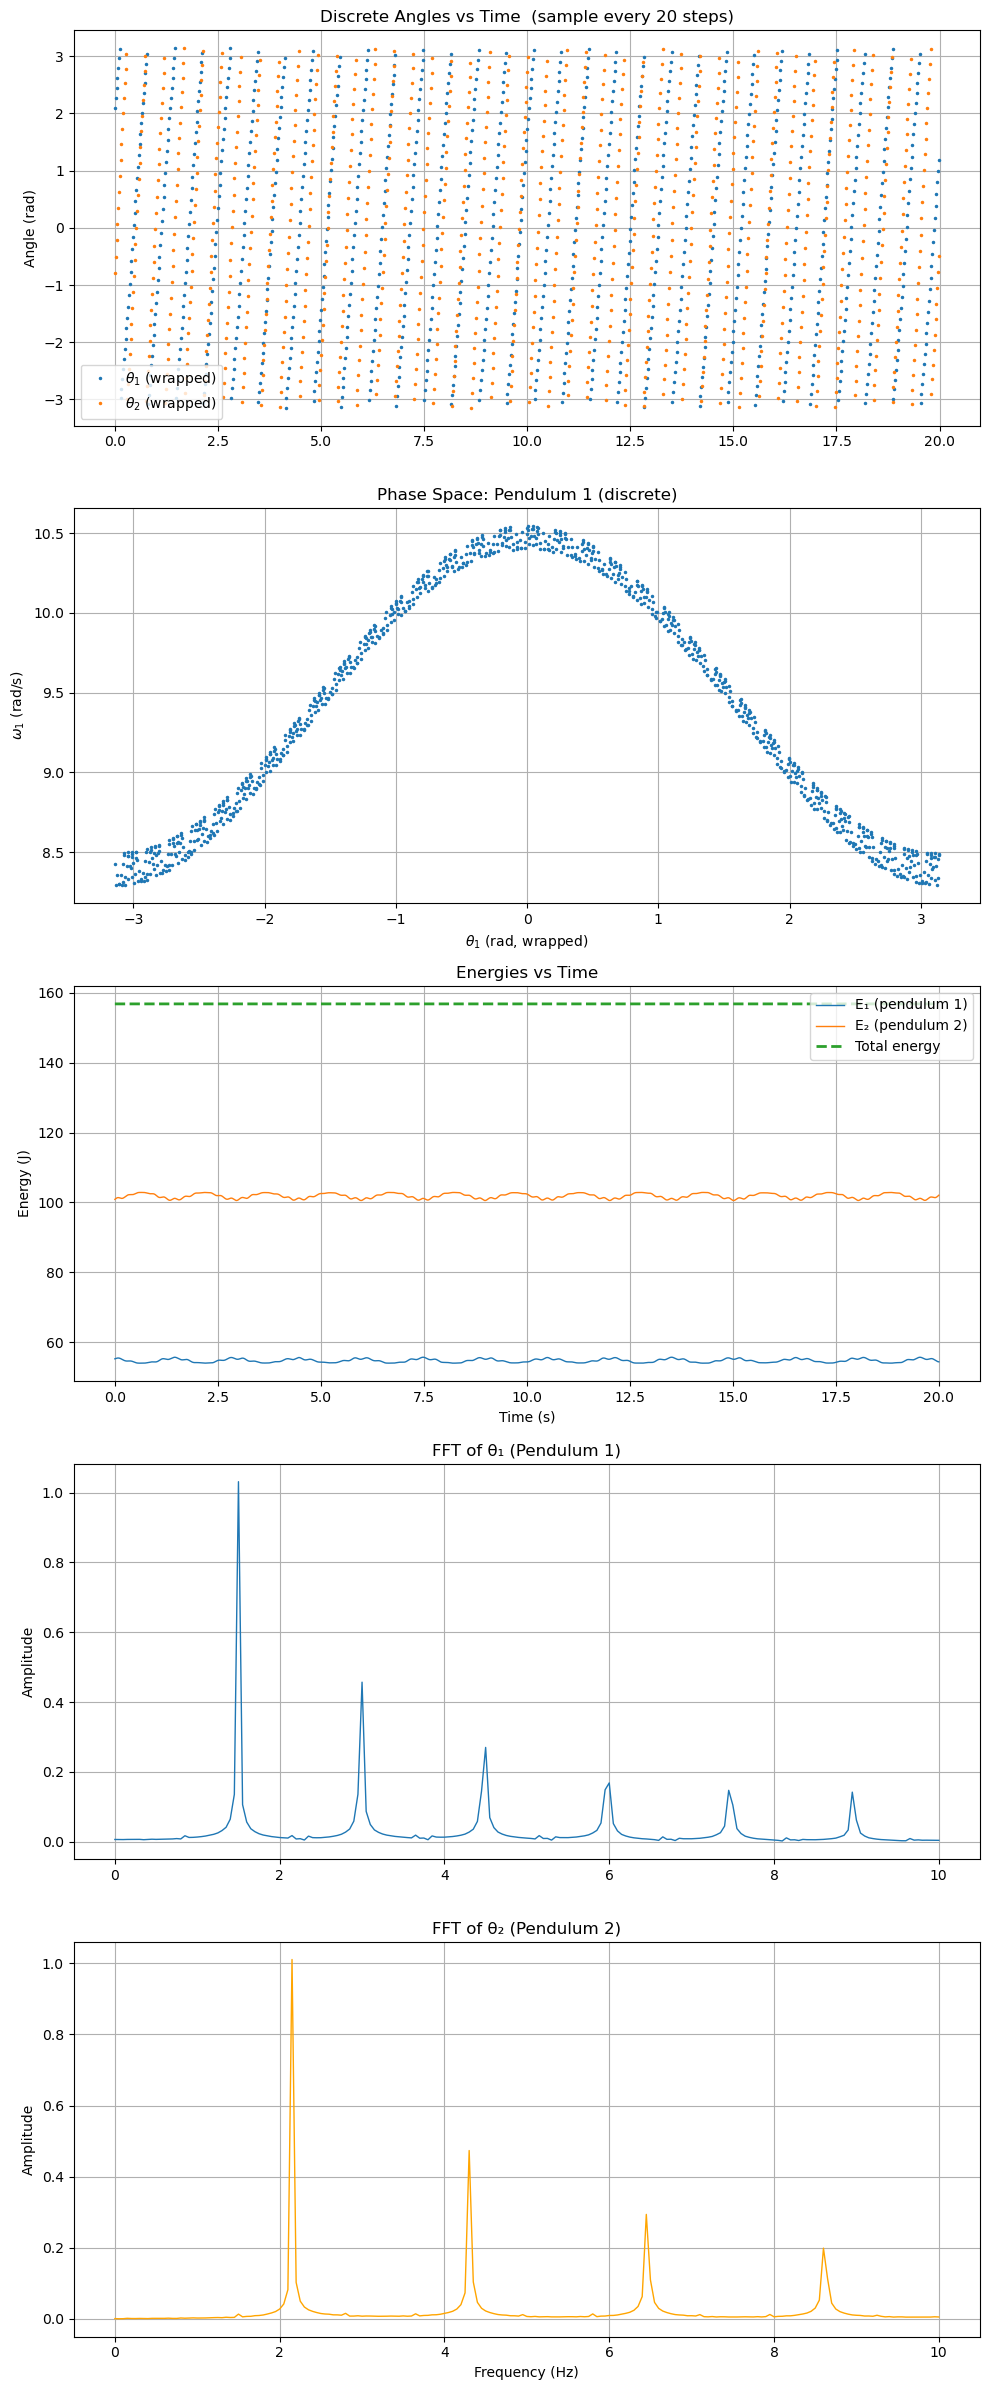

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq

# -------- Parameters --------
g = 9.81      # m/s²
L = 1.0       # m
m = 1.0       # kg
k = 0.6       # N/m          # spring constant (coupling strength)

t_max = 20.0                  # total simulation time (s)
dt    = 0.001                 # time-step (s)

# initial state [θ1, ω1, θ2, ω2]  (radians, rad/s)
y0 = np.array([2*np.pi/3, 9.0,
               -np.pi/4,     14.0])

# -------------------------------------------
def deriv(state):
    """Return derivatives [θ̇1, ω̇1, θ̇2, ω̇2] for the full nonlinear system."""
    θ1, ω1, θ2, ω2 = state
    Δ = np.sin(θ2) - np.sin(θ1)
    α1 = -(g / L) * np.sin(θ1) + (k / m) * Δ * np.cos(θ1)
    α2 = -(g / L) * np.sin(θ2) - (k / m) * Δ * np.cos(θ2)
    return np.array([ω1, α1, ω2, α2])

def rk4_step(state, h):
    """One Runge–Kutta 4 step."""
    k1 = deriv(state)
    k2 = deriv(state + 0.5 * h * k1)
    k3 = deriv(state + 0.5 * h * k2)
    k4 = deriv(state + h * k3)
    return state + (h / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

# Integrate
N = int(t_max / dt)
t = np.linspace(0, t_max, N)
Y = np.zeros((N, 4))
Y[0] = y0
for i in range(N - 1):
    Y[i + 1] = rk4_step(Y[i], dt)

θ1, ω1, θ2, ω2 = Y.T

# --- Helper: wrap angles to (-π, π] ---
wrap = lambda a: (a + np.pi) % (2*np.pi) - np.pi
θ1w, θ2w = wrap(θ1), wrap(θ2)

# ---------- Energies ----------
KE1 = 0.5 * m * L**2 * ω1**2
KE2 = 0.5 * m * L**2 * ω2**2
PE_g1 = m * g * L * (1 - np.cos(θ1))
PE_g2 = m * g * L * (1 - np.cos(θ2))
PE_spring = 0.5 * k * L**2 * (np.sin(θ2) - np.sin(θ1))**2
E1 = KE1 + PE_g1
E2 = KE2 + PE_g2
E_total = E1 + E2 + PE_spring

# ---------- FFTs ----------
freqs = rfftfreq(N, dt)
fft1 = np.abs(rfft(θ1w)) / N
fft2 = np.abs(rfft(θ2w)) / N

# display only up to 10 Hz
lim = freqs <= 10.0
freqs_plot = freqs[lim]
fft1_plot = fft1[lim]
fft2_plot = fft2[lim]

# ---------- Compute accelerations and spring length ----------
Δ_sin    = np.sin(θ2) - np.sin(θ1)
distance = np.abs(L * Δ_sin)   # current spring length (m)

acc1 = -(g / L) * np.sin(θ1) + (k / m) * Δ_sin * np.cos(θ1)
acc2 = -(g / L) * np.sin(θ2) - (k / m) * Δ_sin * np.cos(θ2)

# ---------- Down-sample for scatter plots ----------
skip     = 20                         # plot every 20th point
t_s      = t[::skip]
θ1_s     = θ1w[::skip]
θ2_s     = θ2w[::skip]
ω1_s     = ω1[::skip]
ω2_s     = ω2[::skip]

# ---------- Plot ----------
fig, axes = plt.subplots(5, 1, figsize=(10, 24))

# 1) Angles vs time (discrete)
axes[0].plot(t_s, θ1_s, '.', ms=3, label=r'$\theta_1$ (wrapped)')
axes[0].plot(t_s, θ2_s, '.', ms=3, label=r'$\theta_2$ (wrapped)')
axes[0].set_title(f"Discrete Angles vs Time  (sample every {skip} steps)")
axes[0].set_ylabel("Angle (rad)")
axes[0].legend(); axes[0].grid(True)

# 2) Phase-space portrait (discrete)
axes[1].plot(θ1_s, ω1_s, '.', ms=3)
axes[1].set_title("Phase Space: Pendulum 1 (discrete)")
axes[1].set_xlabel(r'$\theta_1$ (rad, wrapped)')
axes[1].set_ylabel(r'$\omega_1$ (rad/s)')
axes[1].grid(True)

# 3) Energies vs time
axes[2].plot(t, E1, label='E₁ (pendulum 1)', linewidth=1)
axes[2].plot(t, E2, label='E₂ (pendulum 2)', linewidth=1)
axes[2].plot(t, E_total, '--', label='Total energy', linewidth=2)
axes[2].set_title("Energies vs Time")
axes[2].set_xlabel("Time (s)")
axes[2].set_ylabel("Energy (J)")
axes[2].legend(); axes[2].grid(True)

# 4) FFT pendulum 1
xlimit = int(len(freqs_plot))
axes[3].plot(freqs_plot[:xlimit], fft1_plot[:xlimit], linewidth=1)
axes[3].set_title("FFT of θ₁ (Pendulum 1)")
axes[3].set_ylabel("Amplitude")
axes[3].grid(True)

# 5) FFT pendulum 2
axes[4].plot(freqs_plot, fft2_plot, linewidth=1, color='orange')
axes[4].set_title("FFT of θ₂ (Pendulum 2)")
axes[4].set_xlabel("Frequency (Hz)")
axes[4].set_ylabel("Amplitude")
axes[4].grid(True)

plt.tight_layout()
plt.show()


## Double Pendulum Simulation With different Pivot Points

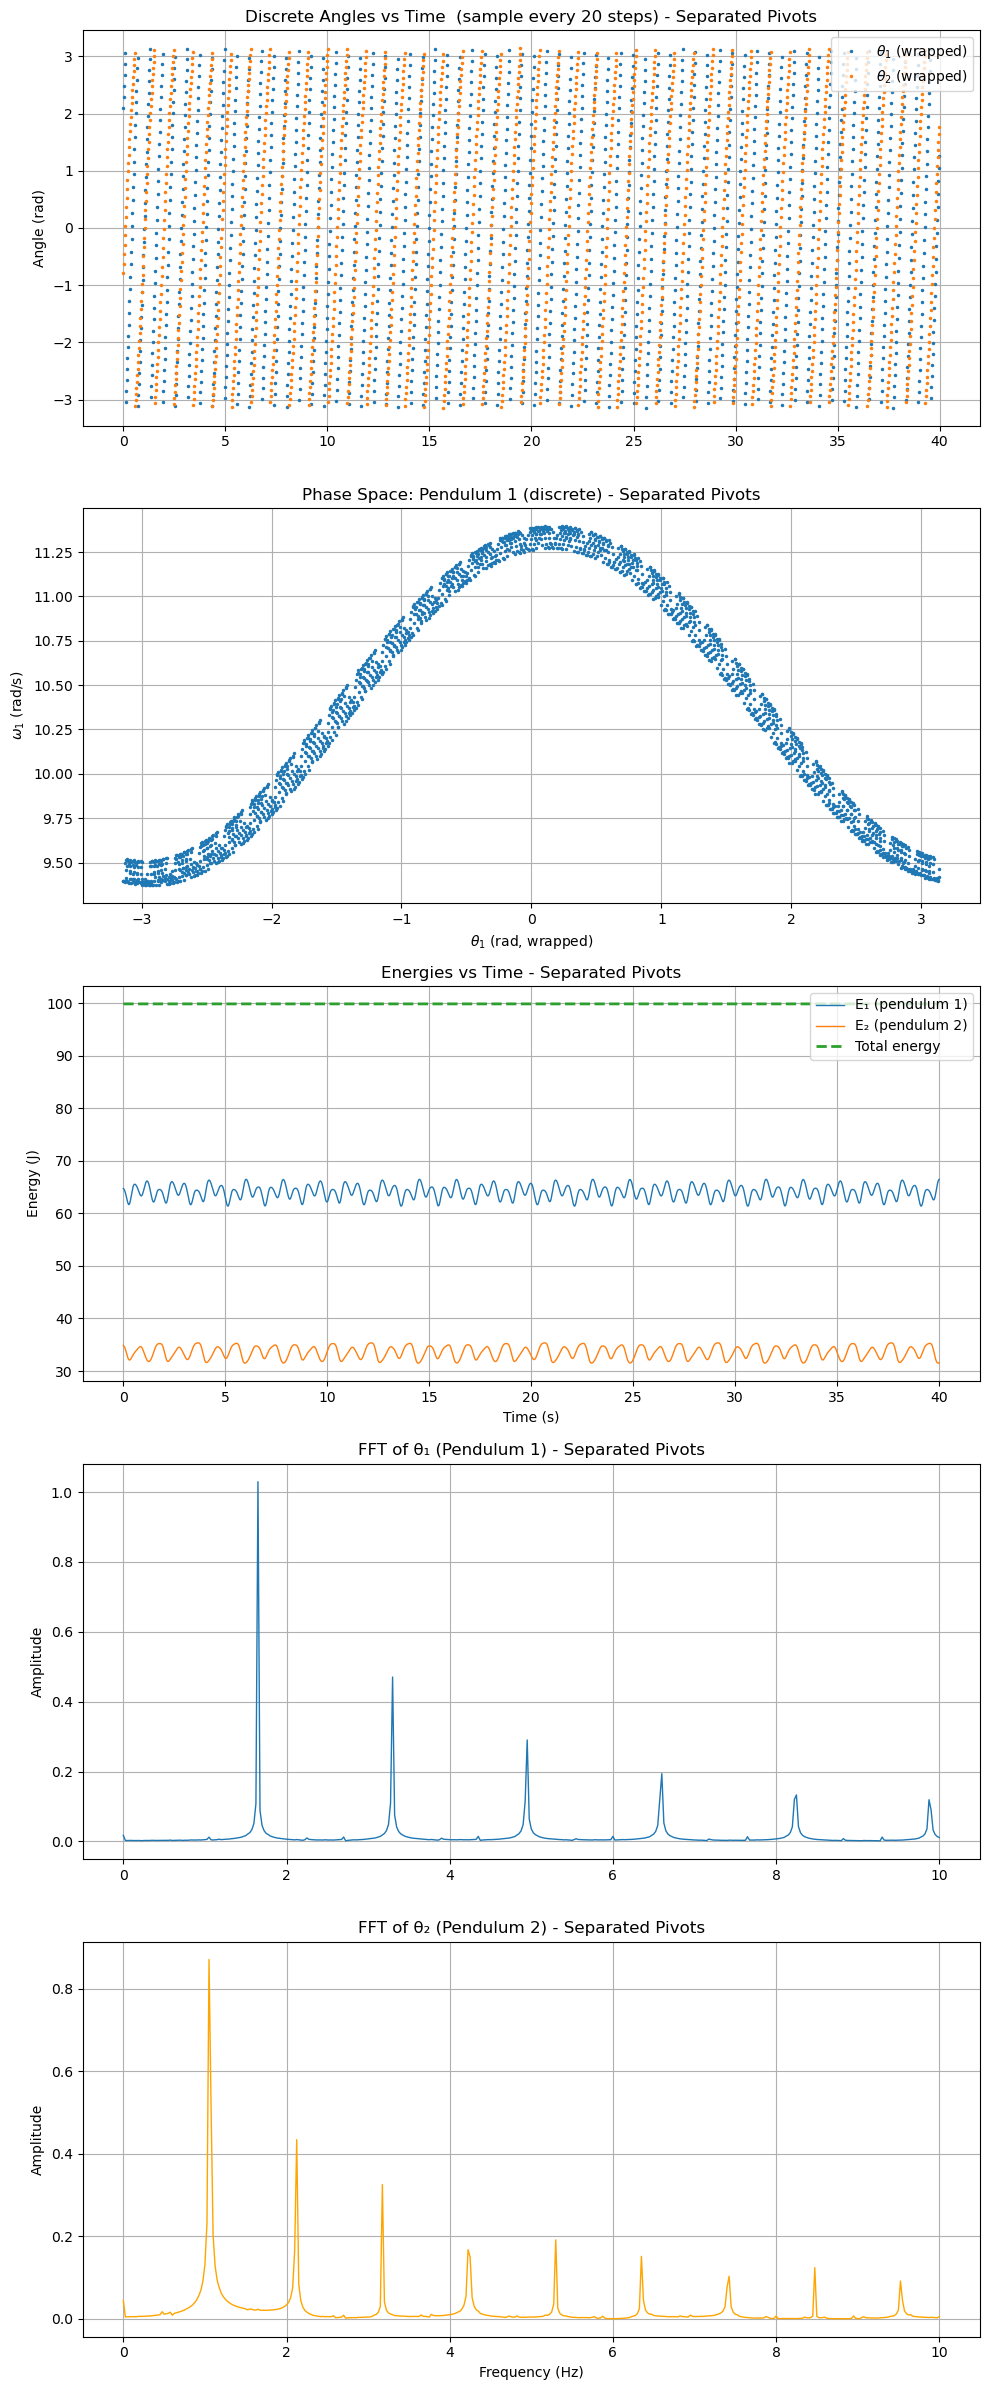

Simulation of coupled pendulums with separate pivot points (horizontal distance = 2.5 m).


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq

# -------- Parameters --------
g = 9.81      # m/s²
L = 1.0       # m
m = 1.0       # kg
k = 0.6       # N/m          # spring constant (coupling strength)
d_pivot = 2.5 # m            # Horizontal distance between pivot points

t_max = 40.0                  # total simulation time (s)
dt    = 0.001                 # time-step (s)

# initial state [θ1, ω1, θ2, ω2]  (radians, rad/s)
y0 = np.array([2*np.pi/3, 10.0,
               -np.pi/4,     8.0])

# -------------------------------------------
def deriv(state):
    """Return derivatives [θ̇1, ω̇1, θ̇2, ω̇2] for the full nonlinear system with separated pivots."""
    θ1, ω1, θ2, ω2 = state

    # Calculate horizontal positions of the bobs
    x1 = L * np.sin(θ1)
    x2 = d_pivot + L * np.sin(θ2)

    # Spring extension (delta_x)
    delta_x = x2 - x1

    # Spring force magnitude (horizontal force)
    F_spring_x = k * delta_x

    # Tangential components of the spring force for each pendulum
    # F_spring_tangential1 = -F_spring_x * np.cos(θ1) (pulls pendulum 1 towards +x if delta_x is +ve)
    # F_spring_tangential2 = -F_spring_x * np.cos(θ2) (pulls pendulum 2 towards -x if delta_x is +ve)
    # The torque is F_tangential * L, and angular acceleration is Torque / (m*L^2) = F_tangential / (m*L)

    α1 = -(g / L) * np.sin(θ1) + (F_spring_x / (m * L)) * np.cos(θ1)
    α2 = -(g / L) * np.sin(θ2) - (F_spring_x / (m * L)) * np.cos(θ2) # Spring pulls θ2 back if x2 > x1

    return np.array([ω1, α1, ω2, α2])

def rk4_step(state, h):
    """One Runge–Kutta 4 step."""
    k1 = deriv(state)
    k2 = deriv(state + 0.5 * h * k1)
    k3 = deriv(state + 0.5 * h * k2)
    k4 = deriv(state + h * k3)
    return state + (h / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

# Integrate
N = int(t_max / dt)
t = np.linspace(0, t_max, N)
Y = np.zeros((N, 4))
Y[0] = y0
for i in range(N - 1):
    Y[i + 1] = rk4_step(Y[i], dt)

θ1, ω1, θ2, ω2 = Y.T

# --- Helper: wrap angles to (-π, π] ---
wrap = lambda a: (a + np.pi) % (2*np.pi) - np.pi
θ1w, θ2w = wrap(θ1), wrap(θ2)

# ---------- Energies ----------
KE1 = 0.5 * m * L**2 * ω1**2
KE2 = 0.5 * m * L**2 * ω2**2
PE_g1 = m * g * L * (1 - np.cos(θ1))
PE_g2 = m * g * L * (1 - np.cos(θ2))

# Calculate horizontal positions for spring potential energy
x1_bobs = L * np.sin(θ1)
x2_bobs = d_pivot + L * np.sin(θ2)
PE_spring = 0.5 * k * (x2_bobs - x1_bobs)**2

E1 = KE1 + PE_g1
E2 = KE2 + PE_g2
E_total = E1 + E2 + PE_spring

# ---------- FFTs ----------
freqs = rfftfreq(N, dt)
fft1 = np.abs(rfft(θ1w)) / N
fft2 = np.abs(rfft(θ2w)) / N

# display only up to 10 Hz
lim = freqs <= 10.0
freqs_plot = freqs[lim]
fft1_plot = fft1[lim]
fft2_plot = fft2[lim]

# ---------- Compute accelerations and spring length ----------
# Recompute accelerations using the modified deriv function for plotting consistency
# (though they are already computed internally in the loop, this is for clarity for plotting)
# This part is just for verification/plotting; the actual simulation uses `deriv`
# We'd ideally recalculate accelerations for plotting if needed, but not strictly necessary for this visualization.
# For consistency, let's recalculate based on the final Y array
accelerations = np.array([deriv(Y[i]) for i in range(N)]).T
acc1 = accelerations[1]
acc2 = accelerations[3]

# The 'distance' in the original code was the *horizontal separation for the old model's spring*.
# Now, it's the actual extension of the spring between the two bobs.
distance = np.abs(x2_bobs - x1_bobs) # current spring extension (m)


# ---------- Down-sample for scatter plots ----------
skip     = 20                         # plot every 20th point
t_s      = t[::skip]
θ1_s     = θ1w[::skip]
θ2_s     = θ2w[::skip]
ω1_s     = ω1[::skip]
ω2_s     = ω2[::skip]

# ---------- Plot ----------
fig, axes = plt.subplots(5, 1, figsize=(10, 24))

# 1) Angles vs time (discrete)
axes[0].plot(t_s, θ1_s, '.', ms=3, label=r'$\theta_1$ (wrapped)')
axes[0].plot(t_s, θ2_s, '.', ms=3, label=r'$\theta_2$ (wrapped)')
axes[0].set_title(f"Discrete Angles vs Time  (sample every {skip} steps) - Separated Pivots")
axes[0].set_ylabel("Angle (rad)")
axes[0].legend(); axes[0].grid(True)

# 2) Phase-space portrait (discrete)
axes[1].plot(θ1_s, ω1_s, '.', ms=3)
axes[1].set_title("Phase Space: Pendulum 1 (discrete) - Separated Pivots")
axes[1].set_xlabel(r'$\theta_1$ (rad, wrapped)')
axes[1].set_ylabel(r'$\omega_1$ (rad/s)')
axes[1].grid(True)

# 3) Energies vs time
axes[2].plot(t, E1, label='E₁ (pendulum 1)', linewidth=1)
axes[2].plot(t, E2, label='E₂ (pendulum 2)', linewidth=1)
axes[2].plot(t, E_total, '--', label='Total energy', linewidth=2)
axes[2].set_title("Energies vs Time - Separated Pivots")
axes[2].set_xlabel("Time (s)")
axes[2].set_ylabel("Energy (J)")
axes[2].legend(); axes[2].grid(True)

# 4) FFT pendulum 1
xlimit = int(len(freqs_plot))
axes[3].plot(freqs_plot[:xlimit], fft1_plot[:xlimit], linewidth=1)
axes[3].set_title("FFT of θ₁ (Pendulum 1) - Separated Pivots")
axes[3].set_ylabel("Amplitude")
axes[3].grid(True)

# 5) FFT pendulum 2
axes[4].plot(freqs_plot, fft2_plot, linewidth=1, color='orange')
axes[4].set_title("FFT of θ₂ (Pendulum 2) - Separated Pivots")
axes[4].set_xlabel("Frequency (Hz)")
axes[4].set_ylabel("Amplitude")
axes[4].grid(True)

plt.tight_layout()
plt.show()

print(f"Simulation of coupled pendulums with separate pivot points (horizontal distance = {d_pivot} m).")